In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error
from tcn import TCN
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.losses import Huber
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [301]:
#load the data
data = pd.read_csv(r'C:\Users\Bhumika Reddy\OneDrive\Desktop\dl-group-project\starbucks_open_7year.csv')
#cheking for missing data
data.fillna(method='ffill', inplace=True)

C:\Users\Bhumika Reddy\AppData\Local\Temp\ipykernel_16656\1396124001.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [302]:
#smoothing the data using a moving average
data['Smoothed_Open'] = data['Open'].rolling(window=5).mean().fillna(data['Open'])

In [303]:
#preprocessing the data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

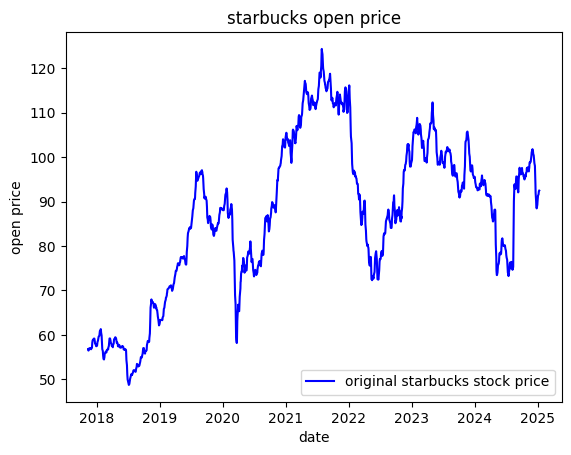

In [304]:
#visualizing the data
plt.plot(data['Smoothed_Open'], label='original starbucks stock price', color='blue')
plt.title('starbucks open price')
plt.xlabel('date')
plt.ylabel('open price')
plt.legend()
plt.show()

In [305]:
#scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Smoothed_Open']])

In [306]:
#creating sequence
time_step=60
def create_sequences(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step-1):
        X.append(data[i:(i + time_step),0])
        Y.append(data[i + time_step,0])
    return np.array(X), np.array(Y)
X, Y = create_sequences(scaled_data, time_step)


In [307]:

#split the data into training,validation and testing
train_size =  0.6
validation_size = 0.2
test_size = 0.2

train_data = int(len(scaled_data) * train_size)
validation_data = int(len(scaled_data)* (train_size + validation_size))



In [308]:
#creating sequences
X_train, Y_train = X[:train_data], Y[:train_data]
X_val, Y_val = X[train_data:validation_data], Y[train_data:validation_data]
X_test, Y_test = X[validation_data:], Y[validation_data:]


In [309]:
#reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print ("Training Data", {X_train.shape}, {Y_train.shape})
print ("Validation Data", {X_val.shape}, {Y_val.shape})
print ("Testing Data", {X_test.shape}, {Y_test.shape})

Training Data {(1080, 60, 1)} {(1080,)}
Validation Data {(360, 60, 1)} {(360,)}
Testing Data {(299, 60, 1)} {(299,)}


In [310]:
#tcn model
#learning_rate=0.001
model = Sequential()
model.add(TCN(input_shape=(X_train.shape[1], 1),nb_filters=256,kernel_size=5,nb_stacks=1,dilations=[1,2,4,8,16]))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(), metrics=['accuracy'])


c:\Users\Bhumika Reddy\OneDrive\Desktop\dl-group-project\venv\Lib\site-packages\tcn\tcn.py:263: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


In [311]:
#traim the model

lr_scheduler=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=20,min_lr=1e-4,verbose=1)

model.fit(X_train,Y_train,
          epochs=100,
          batch_size=8,
          validation_data=(X_val, Y_val),
          callbacks=[lr_scheduler])


Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.0013 - loss: 4.1551 - val_accuracy: 0.0000e+00 - val_loss: 5.2227e-04 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.0020 - loss: 0.0091 - val_accuracy: 0.0000e+00 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.0020 - loss: 0.0022 - val_accuracy: 0.0000e+00 - val_loss: 6.0444e-04 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.0020 - loss: 0.0027 - val_accuracy: 0.0000e+00 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.0020 - loss: 0.0013 - val_accuracy: 0.0000e+00 - val_loss: 2.0303e-04 - learning_rate: 0.0010
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.0020 - loss: 0.0012 - val_accuracy: 0.0000e+00 - val_loss: 6.2711e-04 - learning_rate: 0.0010
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━

In [327]:
test_loss = model.evaluate(X_test, Y_test)
train_loss = model.evaluate(X_train, Y_train)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.0000e+00 - loss: 5.8132e-05
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.0023 - loss: 1.5996e-05


In [ ]:
#evaluation on scaled data
y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, y_pred)
mse = mean_squared_error(Y_test, y_pred)
mape = mean_absolute_percentage_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(f"Scaled MAE: {mae:.4f}")
print(f"Scaled MSE: {mse:.4f}")
print(f"Scaled MAPE: {mape:.4f}")
print(f"Scaled R2 Score: {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Scaled MAE: 0.0088
Scaled MSE: 0.0001
Scaled MAPE: 0.0169
Scaled R2 Score: 0.9899


In [ ]:
#evaluating actual price predictions
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)
test_predict = model.predict(X_test)
y_pred_actual = scaler.inverse_transform(y_pred)
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))
mae_actual = mean_absolute_error(Y_test_actual, y_pred_actual)
mse_actual = mean_squared_error(Y_test_actual, y_pred_actual)
mape_actual = mean_absolute_percentage_error(Y_test_actual, y_pred_actual)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [334]:
print(f'Actual MAE: {mae_actual:.4f}')
print(f'Actual MSE: {mse_actual:.4f}')
print(f'Actual MAPE: {mape_actual:.4f}')



Actual MAE: 0.6618
Actual MSE: 0.7396
Actual MAPE: 0.0074


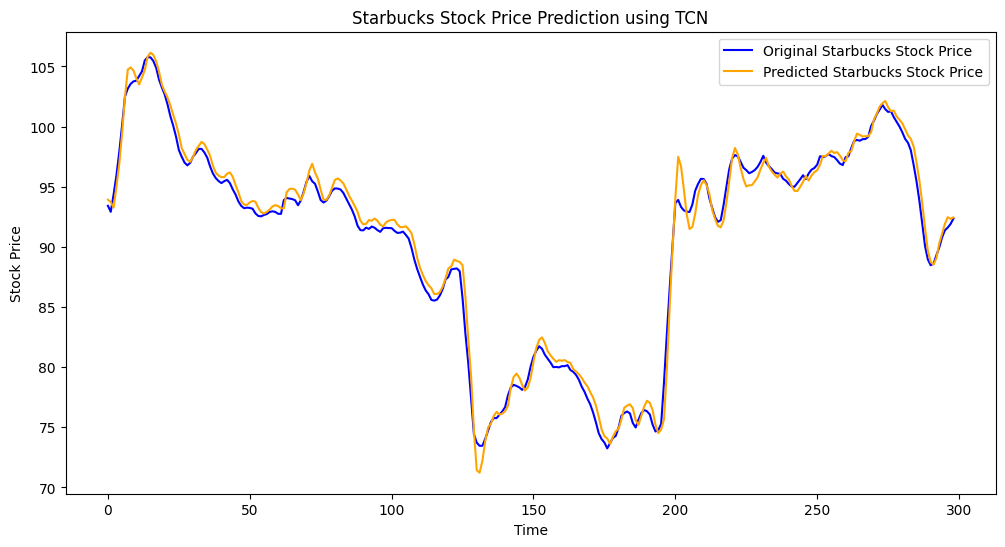

In [339]:
plt.figure(figsize=(12,6))
plt.plot(Y_test_actual, label='Original Starbucks Stock Price', color='blue')
plt.plot(y_pred_actual, label='Predicted Starbucks Stock Price', color='orange')
plt.title('Starbucks Stock Price Prediction using TCN')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [340]:
#actual prediction
def predict_stock(model, last_sequence, future_days=30, scaler=None):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(future_days):
        current_input = current_sequence.reshape((1, time_step, 1))
        next_prediction = model.predict(current_input)[0, 0]
        predictions.append(next_prediction)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_prediction
    
    
    if scaler is not None:
        predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    
    return predictions
last_sequence = scaled_data[-time_step:]
future_predictions = predict_stock(model, last_sequence, 30, scaler=scaler)
future_dates = pd.date_range(start=data.index[-1], periods=31, freq="D")[1:]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

C:\Users\Bhumika Reddy\AppData\Local\Temp\ipykernel_16656\3600588138.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(future_dates, future_predictions, 'r-', label='Future Predictions', color='red')  # Future Predictions


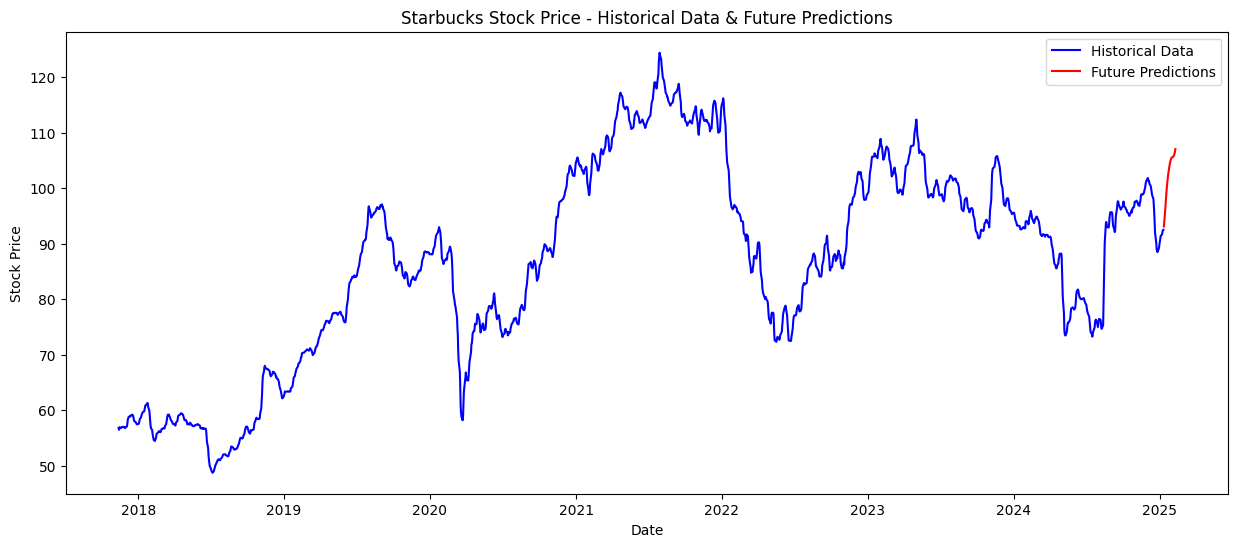

In [341]:
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['Smoothed_Open'], label='Historical Data', color='blue')  # Historical Data
plt.plot(future_dates, future_predictions, 'r-', label='Future Predictions', color='red')  # Future Predictions
plt.title('Starbucks Stock Price - Historical Data & Future Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()